In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import itertools
import functools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
from collections import Counter, defaultdict
from multimodal.multimodal_saycam_data_module import EXTRACTED_FRAMES_DIRNAME
from multimodal.multimodal_data_module import UNK_TOKEN
from analysis_tools.utils import get_n_rows
from analysis_tools.build_data import *
from analysis_tools.frame_visualization import *
import analysis_tools.plotting as plotting


# set default settings for plotting; may change for each plot
figsize = (8, 7)
paper_context = sns.plotting_context('paper')
paper_context.update({
    'font.size': 10.,
    'axes.labelsize': 10.,
    'axes.titlesize': 14.,
    'xtick.labelsize': 8.8,
    'ytick.labelsize': 8.8,
    'legend.fontsize': 8.8,
    'legend.title_fontsize': 9.6,
})
unticked_relation_style = sns.axes_style('white')
unticked_relation_style.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
})
font = 'serif'
sns.set_theme(
    context=paper_context,
    style=unticked_relation_style,
    font=font,
    rc={
        'figure.figsize': figsize,
    }
)

pd.options.display.width = 120

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.pad_inches"] = 0.
plot_format = 'pdf'
saving_fig = False

if saving_fig:
    def _save_fig(fname, format='pdf'):
        print(f'saving plot {fname}')
        plt.savefig(f'plots/{fname}.{format}', transparent=True)
        plt.clf()
    plotting.output_fig = functools.partial(_save_fig, format=plot_format)

output_fig = plotting.output_fig


def plot_dist(data, x=None, xlim_n=50, title=None):
    xlim = (-0.5, xlim_n + 0.5)

    g = sns.displot(df, x=x, discrete=True)
    g.set(xlim=xlim)
    g.figure.set_size_inches(*figsize)
    if title is not None:
        plt.title(title)
        _title = title
    else:
        _title = "distribution"
    output_fig(_title)

    g = sns.displot(df, x=x, kind='ecdf')
    g.set(xlim=xlim)
    g.figure.set_size_inches(*figsize)
    _title_cum = _title + ' (cumulative)'
    if title is not None:
        plt.title(_title_cum)
    output_fig(_title_cum)

In [3]:
get_statistics = False


def sort_data(data, inplace=True, ignore_index=True):
    return data.sort_values(
        ['video_filename', 'timestamps'],
        key=lambda keys: keys.map(lambda lst: lst[0]) if keys.name == 'timestamps' else keys,
        inplace=inplace,
        ignore_index=ignore_index,
    )


data = build_data()
vocab = data.datasets['train'].vocab
print(f'vocab size: {len(vocab)}')

splits = ['train', 'val', 'test']
datasets = {}
for split in splits:
    print(f'{split} split:')
    df = pd.DataFrame(data.datasets[split].data)
    sort_data(df)

    # extract list of tokens from each utterance
    df['tokens'] = df.apply(lambda row: row['utterance'].split(), axis=1)
    df['length'] = df.apply(lambda row: len(row['tokens']), axis=1)

    datasets[split] = df

    if get_statistics:
        # print some data statistics

        total_n_tokens = df['length'].sum()
        print(f"n_examples: {len(df)}")
        for field in ['length', 'num_frames']:
            s = df[field]
            print(f"{field} distribution:")
            print(f"total: {s.sum()}, mean: {s.mean():.3f}, min: {s.min()}, max: {s.max()}")
            counter = Counter(value for index, value in s.iteritems())
            tot = 0
            plot_dist(df, x=field, xlim_n=50, title=f'{field} distribution')
            for value, cnt in sorted(list(counter.items())):
                tot += cnt
                print(f"{tot / len(s):7.2%} {cnt:5} utterances have {field} {value:3}")

        # get OOV rates
        oov_cnt = 0
        unk_cnt = 0
        for i, tokens in enumerate(df['tokens']):
            for token in tokens:
                if token == UNK_TOKEN:
                    unk_cnt += 1
                elif token not in vocab:
                    oov_cnt += 1
        print(f"UNK rate: {unk_cnt / total_n_tokens :6.2%} OOV rate: {oov_cnt / total_n_tokens :6.2%} total OOV rate: {(unk_cnt + oov_cnt) / total_n_tokens :6.2%}")

        for n_gram in range(1, 5):
            gram_name = f'{n_gram}-gram'
            print(f'{gram_name}:')

            counter = Counter()
            for tokens in df['tokens']:
                counter.update(tuple(tokens[i:i+n_gram]) for i in range(len(tokens) - n_gram + 1))
            total_occurances = sum(counter.values())
            print(f'total: {len(counter)} total occurances: {total_occurances}')

            n_oov_grams = 0
            for gram in counter:
                is_oov_gram = False
                for word in gram:
                    if word not in vocab:
                        is_oov_gram = True
                if is_oov_gram:
                    n_oov_grams += 1
            vocab_coverage = 1 - n_oov_grams / len(counter)
            print(f'{n_oov_grams = }  {vocab_coverage = :6.2%}')

            print(f'most common:')
            s = 0
            for gram, cnt in counter.most_common(50):
                s += cnt
                print(f"{s / total_occurances:7.2%} {cnt:5} {' '.join(gram)}")

            cnt_tokens = defaultdict(list)
            for token, cnt in counter.items():
                cnt_tokens[cnt].append(token)
            s = 0
            oov_s = 0
            if n_gram == 1:
                tokenized_utterances = list(df['tokens'])
            for cnt in sorted(cnt_tokens.keys(), reverse=False)[:50]:
                n_tokens = len(cnt_tokens[cnt])
                s += n_tokens
                oov_s += n_tokens * cnt
                print_str = f'cover={oov_s / total_n_tokens:6.2%} {s / len(counter):7.2%} {len(cnt_tokens[cnt]):5} {gram_name}s occurred {cnt:2} times'
                if n_gram == 1:
                    tokenized_utterances = [
                        [UNK_TOKEN if counter[(token,)] == cnt else token
                            for token in tokenized_utterance]
                        for tokenized_utterance in tokenized_utterances]
                    unk_uttr_cnt = sum(int(UNK_TOKEN in tokenized_utterance) for tokenized_utterance in tokenized_utterances)
                    unk_uttr_rate = unk_uttr_cnt / len(tokenized_utterances)
                    print_str = print_str + f' {unk_uttr_rate=:6.2%}'
                print(print_str)

            counter_df = pd.DataFrame(counter.most_common(), columns=[gram_name, 'Count'])
            counter_df[gram_name] = counter_df[gram_name].map(' '.join)
            counter_df.iloc[:100].plot.bar(x=gram_name, width=1)
            plt.xticks(fontsize='xx-small')
            output_fig(f'{gram_name} Frequency')


all_data = pd.concat(datasets.values())
sort_data(all_data)

datasets['all'] = all_data

/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Shuffled training metadata file has already been created. Skipping this step.
Evaluation frames have already been filtered. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Filtered evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipp

all split:
find result index:
Int64Index([10159, 10162, 10170, 10177, 10189, 10222, 10812, 10813, 10814, 10815, 10816, 10817, 30245, 30246, 30263,
            30265, 30267, 30280],
           dtype='int64')
plotting 18/18 = 100.00% results:
frame_width=1.3061224489795917


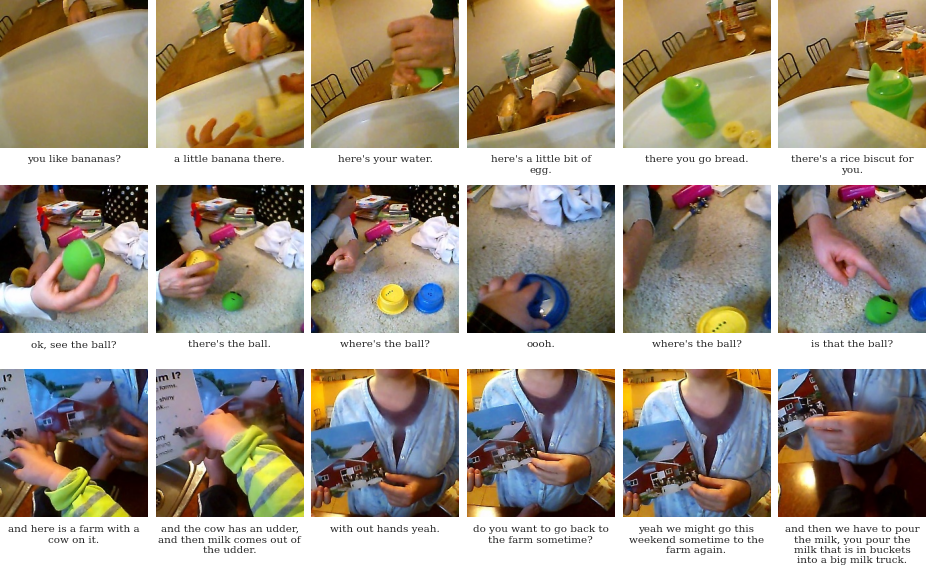

In [4]:
import random
import re
from multimodal.attention_maps import imshow
from matplotlib.animation import FuncAnimation


name = 'sample'
designated_select_index = {
    '': None,
    'ball-1': list(range(10730, 10730+100)),
    'egg': list(range(10171-20, 10171+60)),
    'eating': list(range(19279-20, 19279+20)),
    'breakfast': list(range(3408+14-100+36, 3408+14)),
    'dinner': list(range(36528-40, 36528+40)),
    'chain': list(range(29546, 29551)) + list(range(29570, 29575)),
    'farm-milk': list(range(24905, 24911)),
    'farm-cow-milk-truck': list(range(24982, 24992)),
    'farm-cow-milk': list(range(30245, 30285)),
    'sample': [10159, 10162, 10170, 10177, 10189, 10222] + list(range(10812, 10812+6)) + [30245, 30246, 30263, 30265, 30267, 30280],
}[name]
if designated_select_index is None:
    # search query
    query = input("query: ")
    name = query
    # if True, the entire utterance must match; otherwise must have all words in the query
    match_method = "keyword"
    if match_method == "keyword":
        query_words = query.split()
    elif match_method == "regex":
        query_regex = re.compile(query)
search_in_splits = splits if False else ['all']
animate_all_frames = False
add_captions = True
# display at most N random results
N = 100
n_cols = 6


def show_frame(ax, item, frame_idx, caption=True, **kwargs):
    """Show frame at ax.
    ax: Axes
    item: a row in data
    frame_idx: the frame to show is the frame at frame_idx in item
    caption: bool or str. If True, use utterance; if False, not adding caption
    """
    if caption is True:  # use utterance as caption
        caption = untokenize(item['utterance'])

    # get frame
    frame_filename = item['frame_filenames'][frame_idx]
    img = Image.open(EXTRACTED_FRAMES_DIRNAME / frame_filename)

    imshow(ax, img)
    if caption:
        add_caption(ax, caption[:100], **kwargs)


for split in search_in_splits:
    print(f'{split} split:')
    df = datasets[split]

    if designated_select_index is None:
        # return results matching query
        if match_method == "keyword":
            select_index = df['tokens'].map(lambda tokens: all(query_word in tokens for query_word in query_words))
        elif match_method == "regex":
            select_index = df['utterance'].map(lambda utterance: bool(query_regex.search(utterance)))
    else:
        select_index = designated_select_index
    results = df.loc[select_index]
    print('find result index:')
    print(results.index)

    num_results = min(N, len(results))
    print(f'plotting {num_results}/{len(results)} = {num_results/len(results) if len(results) != 0 else 1.:.2%} results:')
    if num_results == len(results):
        displayed_results = results
    else:
        displayed_results = results.sample(num_results)
        sort_data(displayed_results, ignore_index=False)
        print('sample result index:')
        print(displayed_results.index)

    n_rows = get_n_rows(num_results, n_cols)
    fig, axs, frame_width = frame_subplots(n_rows, n_cols, fig_width=8.)
    print(f'{frame_width=}')

    def show_results(frame_i, frame_frac=None):
        """Show results.
        frame_i: show the frame at frame_i % n_frames.
        frame_frac: if set, ignore frame_i.
                    Can be either float in [0, 1] so we show the frame at index floor(frame_frac * (n_frames - 1)),
                    or "random" so we show a random frame.
        """
        all_axs = itertools.chain.from_iterable(axs)
        for idx, item in displayed_results.iterrows():
            n_frames = len(item['frame_filenames'])
            if frame_frac is None:
                frame_idx = frame_i % n_frames
            else:
                if frame_frac == "random":
                    frame_idx = random.randrange(n_frames)
                else:
                    frame_idx = int(frame_frac * (n_frames - 1))
            show_frame(next(all_axs), item, frame_idx, caption=add_captions, frame_width=frame_width)
        for ax in all_axs:
            ax.axis("off")

    if animate_all_frames:
        n_frames = max((len(result['frame_filenames']) for idx, result in displayed_results.iterrows()), default=0)
        print(f'{n_frames=}')
        n_frames = 2
        anim = FuncAnimation(
            fig,
            show_results,
            frames=n_frames,
            interval=200,
        )

        if False:
            anim.save(f'{query}_{split}.mp4', writer='ffmpeg', fps=5, dpi=100)

        from IPython.display import HTML
        HTML(anim.to_html5_video())

    else:
        show_results(0)

    output_fig(f'frames_{name}_{split}_split')